In [5]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir
from os.path import isfile, join
from json import dump
import time
import pandas as pd
%matplotlib inline

In [6]:
def umat_to_mat(obj):
    return cv2.UMat.get(obj)

In [19]:
def get_metrics(path_directory, image_name, descriptor, keypoints_image_kernel, descriptors_image_kernel, 
                matcher, image_kernel, descriptor_name, ratio=0.75):
    
    image_path = f'{path_directory}/{image_name}'
    
    print(image_path)
    metrics = {'image_name': image_name,'ratio':ratio}
    
    # define start time
    time_start = time.thread_time()
    
    image = cv2.imread(image_path)
    metrics['pixels'] = image.shape[0] * image.shape[1]
    image = cv2.UMat(image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    keypoints_image, descriptors_image = descriptor.detectAndCompute(gray,None)
        
    image_features = cv2.drawKeypoints(umat_to_mat(gray),keypoints_image,umat_to_mat(image_kernel))

    # find matches
    # print(f'type (descriptors_image_kernel) : {type(descriptors_image_kernel)}\n type (descriptors_image): {type(descriptors_image)}')
    matches = matcher.knnMatch(descriptors_image_kernel, descriptors_image, k=2) # sift k = 2
    
    # define end time
    time_end = time.thread_time()
    metrics[f'thread_time_{descriptor_name}'] = time_end - time_start
    
    # compute distance
    good_matches = []
    for m, n in matches:
        if m.distance < ratio * n.distance:
            good_matches.append(m)
    
    image_maches_draw = cv2.drawMatches(image_kernel, keypoints_image_kernel, image, keypoints_image, good_matches, None)
    
    metrics[f'matches_good_ratio_{descriptor_name}'] = len(good_matches) / np.array(matches)[:,1].shape[0]
    
    localization_errors_l1 = np.array([abs(m.distance - n.distance) for m, n in matches])
    localization_errors_l2 = np.array([np.power(m.distance - n.distance, 2) for m, n in matches])
    
    metrics[f'localization_error_l1_mean_{descriptor_name}'] = localization_errors_l1.mean()
    metrics[f'localization_error_l2_mean_{descriptor_name}'] = localization_errors_l2.mean()
    
    return metrics, image_features, umat_to_mat(image_maches_draw)

In [20]:
def define_metrics(descriptor_name, directory_train_name, json_dump_name, name_directory_dump, ratio=0.75, saved_dump=True):
    '''
    descriptor_name - SIFT, AKAZE string format,
    directory_train_name - string format name of directory,
    json_dump_name - string format name of json_dump
    '''
    metrics_images = []

    path_directory = os.path.abspath(os.getcwd())
    path_directory_image = f'{path_directory}/{directory_train_name}'
    
    path_features = f'{directory_train_name}_{descriptor_name}'
    path_features_compared = f'{directory_train_name}_{descriptor_name}_compared'
    try:
#         os.mkdir(path_features)
#         os.mkdir(path_features_compared)
        os.mkdir(name_directory_dump)
        
    except FileExistsError:
            pass
    
    all_training_set = np.array([f for f in listdir(path_directory_image) if isfile(join(path_directory_image, f))])
    all_training_set = np.sort(all_training_set)
    
    
    path_kernel_image = f'{path_directory_image}/{all_training_set[1]}'
    
    print(f'kernel : {path_kernel_image}')
    image_kernel = cv2.imread(path_kernel_image) 
    
    # Turn on GPU
    image_kernel = cv2.UMat(image_kernel)
    
    gray_image_kernel = cv2.cvtColor(image_kernel, cv2.COLOR_BGR2GRAY)
        
    if descriptor_name == 'sift':
        print('sift')
        descriptor = cv2.xfeatures2d.SIFT_create()
        matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
        
    elif descriptor_name == 'akaze':
        print('akaze')
        descriptor = cv2.AKAZE_create()
        matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_BRUTEFORCE_HAMMING)

    else:
        pass
    
    keypoints_image_kernel, descriptors_image_kernel = descriptor.detectAndCompute(gray_image_kernel,None)
    
    for image_file_name in all_training_set[2:]:

        metrics, image_features, image_maches_draw  = get_metrics(path_directory_image, image_file_name, descriptor, keypoints_image_kernel, descriptors_image_kernel,
                              matcher, image_kernel,descriptor_name, ratio)
        metrics_images.append(metrics)
        
#         cv2.imwrite(f'{path_features}/{image_file_name}', image_features)
#         cv2.imwrite(f'{path_features_compared}/{image_file_name}', image_maches_draw)

    
    if saved_dump:
        with open(f'{name_directory_dump}/{json_dump_name}.json', 'w') as f:
            dump(metrics_images, f, indent=4)
    
    return metrics_images

In [21]:
descriptor_name='sift'
directory_train_name='../Lab2/test_lintroller'
json_dump_name='test_lintroller_sift'
name_directory_dump = 'test_dump'

define_metrics(descriptor_name, directory_train_name, json_dump_name, name_directory_dump)

kernel : /home/eduard/gitRepo/object_recognition/Lab3/../Lab2/test_lintroller/lintroller_1.jpg
sift
/home/eduard/gitRepo/object_recognition/Lab3/../Lab2/test_lintroller/lintroller_100.jpg
/home/eduard/gitRepo/object_recognition/Lab3/../Lab2/test_lintroller/lintroller_131.jpg
/home/eduard/gitRepo/object_recognition/Lab3/../Lab2/test_lintroller/lintroller_132.jpg
/home/eduard/gitRepo/object_recognition/Lab3/../Lab2/test_lintroller/lintroller_133.jpg
/home/eduard/gitRepo/object_recognition/Lab3/../Lab2/test_lintroller/lintroller_134.jpg
/home/eduard/gitRepo/object_recognition/Lab3/../Lab2/test_lintroller/lintroller_135.jpg
/home/eduard/gitRepo/object_recognition/Lab3/../Lab2/test_lintroller/lintroller_136.jpg
/home/eduard/gitRepo/object_recognition/Lab3/../Lab2/test_lintroller/lintroller_137.jpg
/home/eduard/gitRepo/object_recognition/Lab3/../Lab2/test_lintroller/lintroller_138.jpg
/home/eduard/gitRepo/object_recognition/Lab3/../Lab2/test_lintroller/lintroller_139.jpg
/home/eduard/gitRepo

[{'image_name': 'lintroller_100.jpg',
  'ratio': 0.75,
  'pixels': 983040,
  'thread_time_sift': 0.18412817999998765,
  'matches_good_ratio_sift': 0.019629225736095966,
  'localization_error_l1_mean_sift': 17.003140889441305,
  'localization_error_l2_mean_sift': 577.5394958743614},
 {'image_name': 'lintroller_131.jpg',
  'ratio': 0.75,
  'pixels': 76800,
  'thread_time_sift': 0.025408393999995837,
  'matches_good_ratio_sift': 0.020719738276990186,
  'localization_error_l1_mean_sift': 21.09336252326924,
  'localization_error_l2_mean_sift': 838.0151766218071},
 {'image_name': 'lintroller_132.jpg',
  'ratio': 0.75,
  'pixels': 76800,
  'thread_time_sift': 0.021549702000001503,
  'matches_good_ratio_sift': 0.03816793893129771,
  'localization_error_l1_mean_sift': 34.65130696769889,
  'localization_error_l2_mean_sift': 2202.8410154868097},
 {'image_name': 'lintroller_133.jpg',
  'ratio': 0.75,
  'pixels': 76800,
  'thread_time_sift': 0.02162435500000015,
  'matches_good_ratio_sift': 0.02944

In [22]:
descriptor_name='akaze'
directory_train_name='../Lab2/test_lintroller'
json_dump_name='test_lintroller_akaze'
name_directory_dump = 'test_dump'

define_metrics(descriptor_name, directory_train_name, json_dump_name, name_directory_dump)

kernel : /home/eduard/gitRepo/object_recognition/Lab3/../Lab2/test_lintroller/lintroller_1.jpg
akaze
/home/eduard/gitRepo/object_recognition/Lab3/../Lab2/test_lintroller/lintroller_100.jpg
/home/eduard/gitRepo/object_recognition/Lab3/../Lab2/test_lintroller/lintroller_131.jpg
/home/eduard/gitRepo/object_recognition/Lab3/../Lab2/test_lintroller/lintroller_132.jpg
/home/eduard/gitRepo/object_recognition/Lab3/../Lab2/test_lintroller/lintroller_133.jpg
/home/eduard/gitRepo/object_recognition/Lab3/../Lab2/test_lintroller/lintroller_134.jpg
/home/eduard/gitRepo/object_recognition/Lab3/../Lab2/test_lintroller/lintroller_135.jpg
/home/eduard/gitRepo/object_recognition/Lab3/../Lab2/test_lintroller/lintroller_136.jpg
/home/eduard/gitRepo/object_recognition/Lab3/../Lab2/test_lintroller/lintroller_137.jpg
/home/eduard/gitRepo/object_recognition/Lab3/../Lab2/test_lintroller/lintroller_138.jpg
/home/eduard/gitRepo/object_recognition/Lab3/../Lab2/test_lintroller/lintroller_139.jpg
/home/eduard/gitRep

[{'image_name': 'lintroller_100.jpg',
  'ratio': 0.75,
  'pixels': 983040,
  'thread_time_akaze': 0.1176441949999969,
  'matches_good_ratio_akaze': 0.006060606060606061,
  'localization_error_l1_mean_akaze': 6.721212121212122,
  'localization_error_l2_mean_akaze': 83.38181818181818},
 {'image_name': 'lintroller_131.jpg',
  'ratio': 0.75,
  'pixels': 76800,
  'thread_time_akaze': 0.024178683000002366,
  'matches_good_ratio_akaze': 0.01818181818181818,
  'localization_error_l1_mean_akaze': 9.687878787878788,
  'localization_error_l2_mean_akaze': 163.9060606060606},
 {'image_name': 'lintroller_132.jpg',
  'ratio': 0.75,
  'pixels': 76800,
  'thread_time_akaze': 0.022588800999997716,
  'matches_good_ratio_akaze': 0.021212121212121213,
  'localization_error_l1_mean_akaze': 12.715151515151515,
  'localization_error_l2_mean_akaze': 252.79393939393938},
 {'image_name': 'lintroller_133.jpg',
  'ratio': 0.75,
  'pixels': 76800,
  'thread_time_akaze': 0.02727216600000304,
  'matches_good_ratio_ak

In [17]:
descriptor_name='akaze'
directory_train_name='Train_s'
json_dump_name='train_s_akaze'
name_directory_dump = 'train_dump'

define_metrics(descriptor_name, directory_train_name, json_dump_name, name_directory_dump)

kernel : /home/eduard/gitRepo/object_recognition/Lab3/Train_s/sandglass_0.jpg
akaze
/home/eduard/gitRepo/object_recognition/Lab3/Train_s/sandglass_10.jpg
/home/eduard/gitRepo/object_recognition/Lab3/Train_s/sandglass_11.jpg
/home/eduard/gitRepo/object_recognition/Lab3/Train_s/sandglass_12.jpg
/home/eduard/gitRepo/object_recognition/Lab3/Train_s/sandglass_13.jpg
/home/eduard/gitRepo/object_recognition/Lab3/Train_s/sandglass_14.jpg
/home/eduard/gitRepo/object_recognition/Lab3/Train_s/sandglass_15.jpg
/home/eduard/gitRepo/object_recognition/Lab3/Train_s/sandglass_16.jpg
/home/eduard/gitRepo/object_recognition/Lab3/Train_s/sandglass_17.jpg
/home/eduard/gitRepo/object_recognition/Lab3/Train_s/sandglass_19.jpg
/home/eduard/gitRepo/object_recognition/Lab3/Train_s/sandglass_2.jpg
/home/eduard/gitRepo/object_recognition/Lab3/Train_s/sandglass_20.jpg
/home/eduard/gitRepo/object_recognition/Lab3/Train_s/sandglass_21.jpg
/home/eduard/gitRepo/object_recognition/Lab3/Train_s/sandglass_22.jpg
/home/e

error: OpenCV(4.4.0) /tmp/pip-req-build-yln3mf6z/opencv/modules/core/src/batch_distance.cpp:274: error: (-215:Assertion failed) type == src2.type() && src1.cols == src2.cols && (type == CV_32F || type == CV_8U) in function 'batchDistance'


## Preparing data

In [21]:
from os import walk
from PIL import Image


def pretrain_data(input_directory, output_directory, size=(150,150)):
    
    print(f'dir:\t{input_directory}')
    try:    
        os.mkdir(output_directory) 
    except FileExistsError:
        pass
    
    f = []
    for (dirpath, dirnames, filenames) in walk(input_directory):
        f.extend(filenames)
        break
    
    for image_name in sorted(f):
        
        print(f'image:\t{image_name}')
        image1 = Image.open(f'{input_directory}/{image_name}')

        img_resized = image1.resize(size)
        img_resized.save(f'{output_directory}/{image_name}')

In [22]:
def get_list_images(input_directory):
    f = []
    for (dirpath, dirnames, filenames) in walk(input_directory):
        f.extend(filenames)
        break
    f_sorted = sorted(f)
    train_set_images = [Image.open(f'{input_directory}/{image_name}') for image_name in f_sorted]
    images_get = np.array([np.array(x) for x in train_set_images])
    
    return  images_get, np.array([name[:-4] for name in f_sorted])

In [106]:
input_directory = 'Test_set_origin//'
output_directory = 'Test_set_prepared_origin_ml/'
pretrain_data(input_directory, output_directory)

dir:	Test_set_origin//
image:	lintroller_100.jpg
image:	lintroller_150.jpg
image:	lintroller_151.jpg
image:	lintroller_152.jpg
image:	lintroller_153.jpg
image:	lintroller_154.jpg
image:	lintroller_155.jpg
image:	lintroller_156.jpg
image:	lintroller_157.jpg
image:	lintroller_158.jpg
image:	lintroller_159.jpg
image:	lintroller_160.jpg
image:	lintroller_161.jpg
image:	lintroller_162.jpg
image:	lintroller_163.jpg
image:	lintroller_164.jpg
image:	lintroller_165.jpg
image:	lintroller_166.jpg
image:	lintroller_167.jpg
image:	lintroller_168.jpg
image:	lintroller_169.jpg
image:	lintroller_81.jpg
image:	lintroller_84.jpg
image:	lintroller_85.jpg
image:	lintroller_87.jpg
image:	lintroller_88.jpg
image:	lintroller_89.jpg
image:	lintroller_90.jpg
image:	lintroller_91.jpg
image:	lintroller_92.jpg
image:	lintroller_93.jpg
image:	lintroller_94.jpg
image:	lintroller_95.jpg
image:	lintroller_96.jpg
image:	lintroller_97.jpg
image:	lintroller_98.jpg
image:	lintroller_99.jpg
image:	sandglass_100.jpg
image:

## Create model

<a href='https://www.tensorflow.org/tutorials/images/classification'> Source Link</a>

In [62]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pandas as pd
from sklearn.model_selection import train_test_split

## Turn on GPU for tensorflow

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
# assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Simple neural network

In [68]:
directory_train = 'Train_set_prepared_origin_ml/'
directory_test = 'Test_set_prepared_origin_ml/'
train_set_images, train_names = get_list_images(directory_train)
test_set_images, test_names = get_list_images(directory_test)

df_train = pd.read_excel('tabular_data/train.xlsx')
df_test = pd.read_excel('tabular_data/test.xlsx')

train_labels = np.array(df_train.sort_values(['Class']).Label)
test_labels = np.array(df_test.sort_values(['Class']).Label)

train_set_images, test_set_images = train_set_images/255, test_set_images/255

In [70]:
print(train_names.shape)
print(train_valid_set_images.shape)
print(test_set_images.shape)
print(test_labels.shape)

(160,)
(160, 150, 150, 3)
(52, 150, 150, 3)
(52,)


In [73]:
model1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(150,150,3)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(3, activation=tf.nn.softmax)
])
model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model1.fit(train_set_images, train_labels, epochs=10, validation_split=0.3)

Epoch 1/10
4/4 [==============================] - 0s 44ms/step - loss: 20.0302 - accuracy: 0.6137 - val_loss: 21.8036 - val_accuracy: 0.7500
Epoch 2/10
4/4 [==============================] - 0s 17ms/step - loss: 10.5943 - accuracy: 0.5497 - val_loss: 23.3430 - val_accuracy: 0.0000e+00
Epoch 3/10
4/4 [==============================] - 0s 17ms/step - loss: 7.3086 - accuracy: 0.3948 - val_loss: 17.1201 - val_accuracy: 0.0000e+00
Epoch 4/10
4/4 [==============================] - 0s 16ms/step - loss: 2.7573 - accuracy: 0.7055 - val_loss: 3.6757 - val_accuracy: 0.7292
Epoch 5/10
4/4 [==============================] - 0s 16ms/step - loss: 2.5293 - accuracy: 0.5890 - val_loss: 3.8914 - val_accuracy: 0.5000
Epoch 6/10
4/4 [==============================] - 0s 16ms/step - loss: 0.9928 - accuracy: 0.7982 - val_loss: 8.8121 - val_accuracy: 0.1042
Epoch 7/10
4/4 [==============================] - 0s 16ms/step - loss: 1.2456 - accuracy: 0.7580 - val_loss: 2.7059 - val_accuracy: 0.6042
Epoch 8/10
4/4

In [75]:
model.evaluate(test_set_images, test_labels)

2/2 [==============================] - 0s 8ms/step - loss: 1.5493 - accuracy: 0.2500


[1.5492867231369019, 0.25]

In [88]:
## saved
class_label = 2
df_test[df_test.Label == class_label].sort_values(by=['Class']).to_excel(f'tabular_data/label_test_{class_label}.xlsx')
df_train[df_train.Label == 1].sort_values(by=['Class']).to_excel('tabular_data/label_1.xlsx')

In [5]:
batch_size = 10
img_height = 150
img_width = 150
data_dir = 'Train_set_prepared'
validation_split=0.3


train_ds = keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=validation_split,
      subset="training",
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)

Found 160 files belonging to 3 classes.
Using 112 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=validation_split,
      subset="validation",
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)

Found 160 files belonging to 3 classes.
Using 48 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['lintroller', 'nothing', 'sandglass']


## Visualize the data

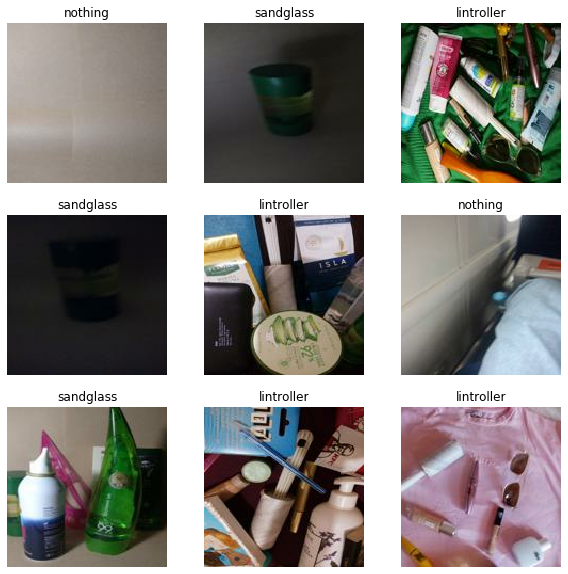

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
      for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(10, 150, 150, 3)
(10,)


## Configure the dataset for performance

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(20).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

In [11]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


## Create the model

In [13]:
class MyCallBack(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, log={}):
        if log.get('accuracy') > 0.98:
            self.model.stop_training = True

In [30]:
num_classes = 3
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
#     layers.Conv2D(64, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
    ])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

epochs=3
history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs
      # callbacks=[callback]
)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 43808)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)              

In [31]:
model.evaluate(test_set_images, test_labels)

2/2 [==============================] - 0s 6ms/step - loss: 1.5966 - accuracy: 0.3077


[1.5966306924819946, 0.3076923191547394]

## Visualize training results

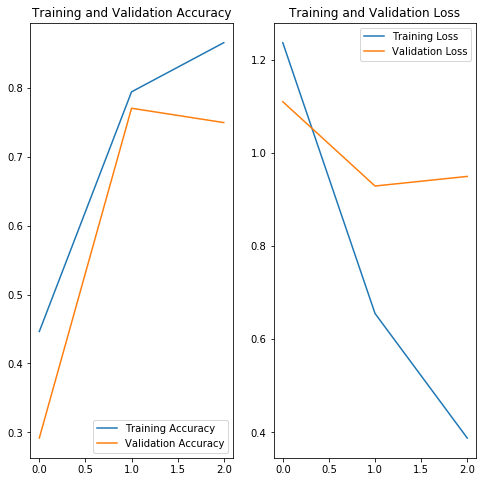

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Data augmentation

In [33]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

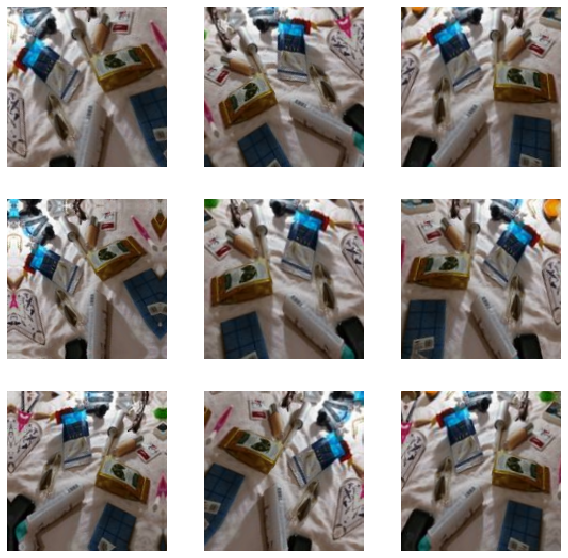

In [70]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Dropout

In [47]:
model2 = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1/255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model2.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
rescaling_11 (Rescaling)     (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 37, 37, 64)      

In [45]:
epochs = 7
history = model2.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs
)

Epoch 1/7
12/12 [==============================] - 1s 22ms/step - loss: 1.4519 - accuracy: 0.3486 - val_loss: 1.3477 - val_accuracy: 0.2917
Epoch 2/7
12/12 [==============================] - 0s 14ms/step - loss: 1.0862 - accuracy: 0.5197 - val_loss: 1.1541 - val_accuracy: 0.2917
Epoch 3/7
12/12 [==============================] - 0s 13ms/step - loss: 0.9839 - accuracy: 0.5695 - val_loss: 1.3101 - val_accuracy: 0.7708
Epoch 4/7
12/12 [==============================] - 0s 13ms/step - loss: 0.7764 - accuracy: 0.7900 - val_loss: 1.1100 - val_accuracy: 0.7500
Epoch 5/7
12/12 [==============================] - 0s 12ms/step - loss: 0.5104 - accuracy: 0.8159 - val_loss: 1.3150 - val_accuracy: 0.7500
Epoch 6/7
12/12 [==============================] - 0s 12ms/step - loss: 0.3595 - accuracy: 0.8965 - val_loss: 1.2976 - val_accuracy: 0.7500
Epoch 7/7
12/12 [==============================] - 0s 12ms/step - loss: 0.3285 - accuracy: 0.9214 - val_loss: 1.5194 - val_accuracy: 0.7500


In [48]:
model2.evaluate(test_set_images, test_labels)

2/2 [==============================] - 0s 6ms/step - loss: 1.0804 - accuracy: 0.5056


[1.0846331119537354, 0.4615384638309479]

## Visualize training results

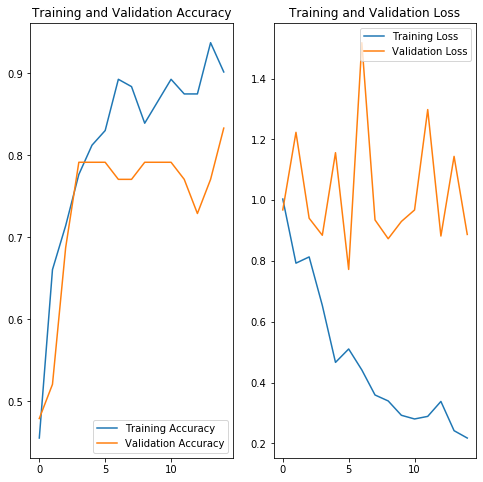

In [84]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Evaluate

In [90]:
data_dir = 'Test_set_prepared/'

train_ds = keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=0,
      subset="test",
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)

ValueError: If `subset` is set, `validation_split` must be set, and inversely.

In [89]:
test_direct = 'Test_set_prepared/'

img_test = keras.preprocessing.image.load_img(
    test_direct, target_size=(img_height, img_width)
)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

IsADirectoryError: [Errno 21] Is a directory: 'Test_set_prepared/'